In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
!rsync -avs nama:astra1802/analysis .

receiving incremental file list
analysis/
analysis/sa_2000_1.0.flow.dbf
analysis/sa_2000_1.0.flow.fix
analysis/sa_2000_1.0.flow.prj
analysis/sa_2000_1.0.flow.shp
analysis/sa_2000_1.0.flow.shx
analysis/sa_2000_1.0.prices.csv
analysis/sa_2000_1.0.services.csv
analysis/sa_2000_1.0.traces.csv
analysis/sa_2000_1.0.trips.csv
analysis/sa_2500_1.0.flow.dbf
analysis/sa_2500_1.0.flow.fix
analysis/sa_2500_1.0.flow.prj
analysis/sa_2500_1.0.flow.shp
analysis/sa_2500_1.0.flow.shx
analysis/sa_2500_1.0.prices.csv
analysis/sa_2500_1.0.services.csv
analysis/sa_2500_1.0.traces.csv
analysis/sa_2500_1.0.trips.csv

sent 1,072 bytes  received 405,116,708 bytes  5,365,798.41 bytes/sec
total size is 2,645,072,709  speedup is 6.53


In [3]:
fleet_sizes = [25, 50, 75, 100, 200, 300, 400, 500, 600, 700, 900, 1100, 1300, 1500, 2000, 2500]
minimum_distances = [1.0]
scenarios = ["lu", "lg", "sa"]

ROAD_MODES = ["car", "prav3", "prav4", "prav5"]

records = []

total_samples = len(fleet_sizes) * len(minimum_distances) * len(scenarios)

with tqdm_notebook(total = total_samples) as progress:
    for scenario in scenarios:
        for fleet_size in fleet_sizes:
            for minimum_distance in minimum_distances:
                try:
                    name = "%s_%d_%.1f" % (scenario, fleet_size, minimum_distance)

                    df_prices = pd.read_csv("analysis/%s.prices.csv" % name, sep = ";")
                    price = df_prices["active_price"].values[-1]

                    df_services = pd.read_csv("analysis/%s.services.csv" % name, sep = ";")
                    median_waiting_time = df_services["waiting_time"].median()
                    mean_waiting_time = df_services["waiting_time"].mean()
                    q90_waiting_time = df_services["waiting_time"].quantile(0.9)
                    q10_waiting_time = df_services["waiting_time"].quantile(0.1)

                    df_traces = pd.read_csv("analysis/%s.traces.csv" % name, sep = ";")
                    av_customer_distance = df_traces[df_traces["occupancy"] > 0]["distance"].sum() * 1e-3
                    av_empty_distance = df_traces[df_traces["occupancy"] == 0]["distance"].sum() * 1e-3

                    df_trips = pd.read_csv("analysis/%s.trips.csv" % name, sep = ";")
                    private_distance = df_trips[df_trips["mode"].isin(ROAD_MODES)]["network_distance"].sum()

                    av_trips = np.count_nonzero(df_trips["mode"] == "av")
                    
                    av_share = df_trips[df_trips["mode"] == "av"]["network_distance"].sum() / df_trips["network_distance"].sum()
                    pt_share = df_trips[df_trips["mode"] == "pt"]["network_distance"].sum() / df_trips["network_distance"].sum()

                    total_distance = av_customer_distance + av_empty_distance + private_distance

                    records.append((
                        scenario, fleet_size, minimum_distance,
                        price, av_trips,
                        mean_waiting_time, median_waiting_time, q10_waiting_time, q90_waiting_time, 
                        av_customer_distance, av_empty_distance, private_distance, av_share, pt_share
                    ))
                except FileNotFoundError as e:
                    #print(e)
                    pass
                
                progress.update()
            
df = pd.DataFrame.from_records(records, columns = [
    "scenario", "fleet_size", "minimum_distance", "price", "av_trips",
    "mean_waiting_time", "median_waiting_time", "q10_waiting_time", "q90_waiting_time",
    "av_customer_distance", "av_empty_distance", "private_distance", "av_share", "pt_share"
])

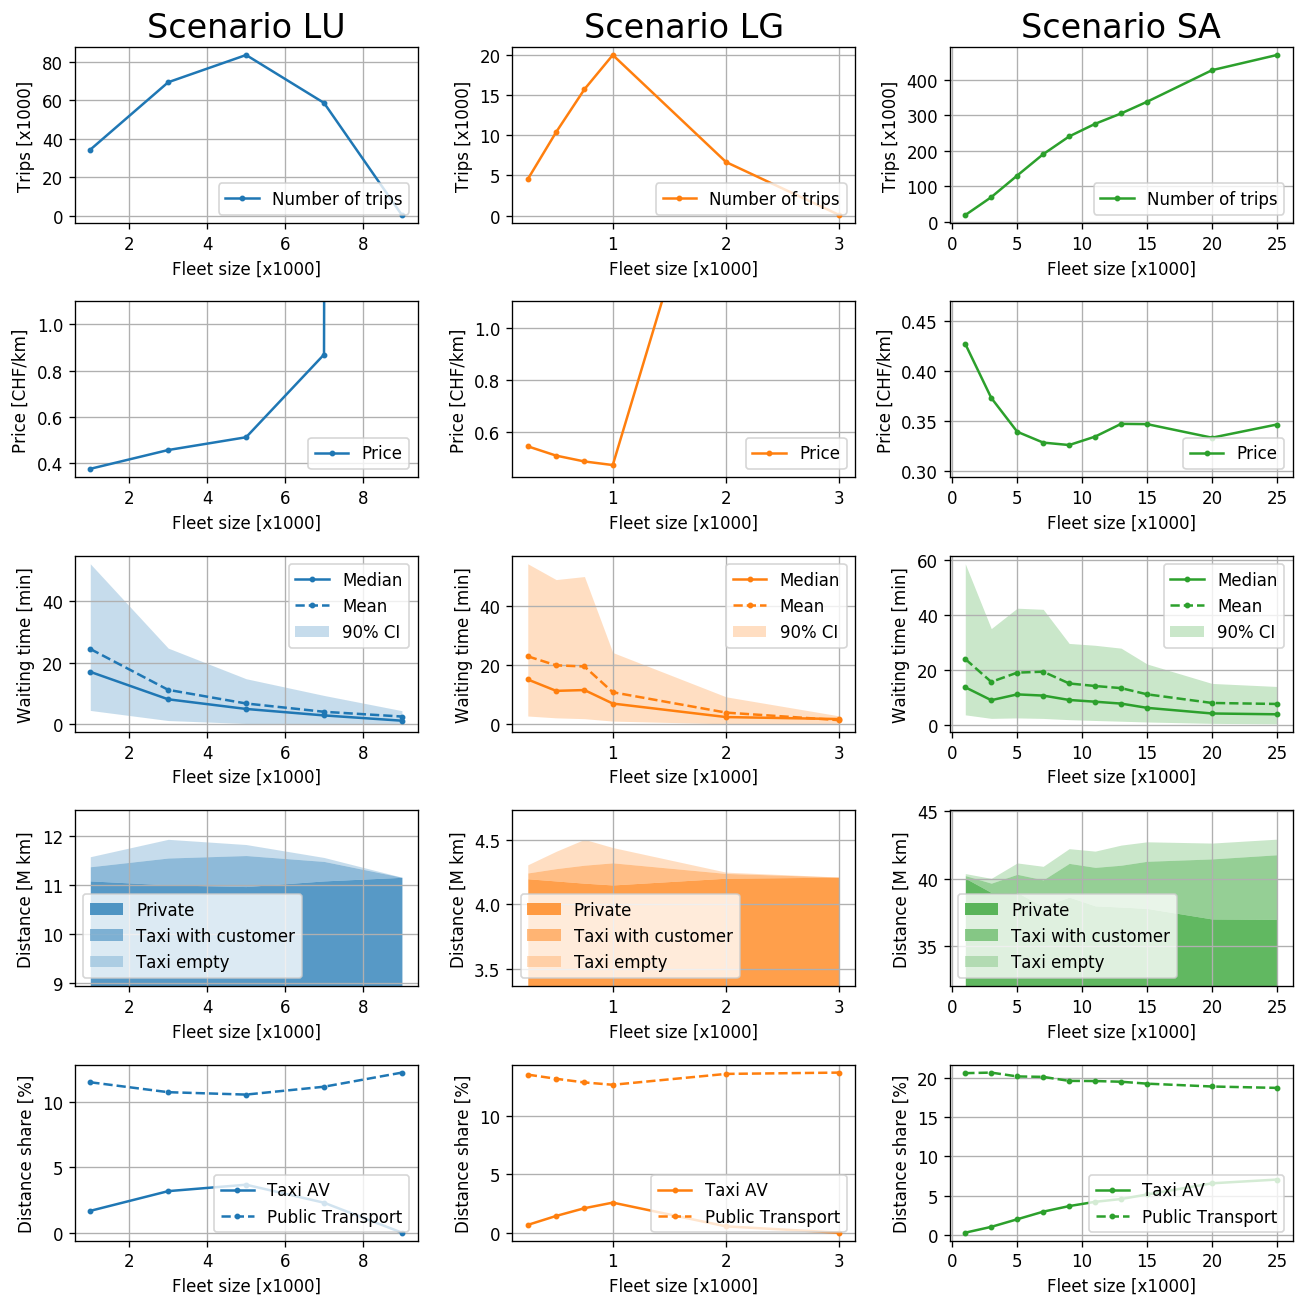

In [4]:
plt.figure(dpi = 120, figsize = (11.0, 11.0))

font_size = 10
colors = ["C0", "C1", "C2"]
maximum_fleet_sizes = { "lu": 1000, "lg": 300, "sa": np.inf }

for si, (scenario, color) in enumerate(zip(scenarios, colors)):
    f = (df["scenario"] == scenario) & (df["minimum_distance"] == 1.0)
    f &= df["fleet_size"] <= maximum_fleet_sizes[scenario]
    
    # Number of trips
    plt.subplot(5, len(scenarios), 0 * len(scenarios) + si + 1)
    
    plt.plot(
        df[f]["fleet_size"].values / 100,
        df[f]["av_trips"].values / 100,
        color = color, marker = ".", markersize = 5, label = "Number of trips"
    )
    
    plt.ylabel("Trips [x1000]")
    plt.xlabel("Fleet size [x1000]")
    plt.grid()
    plt.legend(loc = "lower right", fontsize = font_size)
    
    plt.title("Scenario %s" % scenario.upper(), fontsize = font_size * 2.0)
    
    # Price
    plt.subplot(5, len(scenarios), 1 * len(scenarios) + si + 1)
    
    plt.plot(
        df[f]["fleet_size"].values / 100,
        df[f]["price"].values,
        color = color, marker = ".", markersize = 5, label = "Price"
    )
    
    minimum = df[f]["price"].min() * 0.9
    plt.ylim([0.0 if np.isnan(minimum) else minimum, min(1.0, df[f]["price"].max()) * 1.1])
    plt.ylabel("Price [CHF/km]")
    plt.xlabel("Fleet size [x1000]")
    plt.grid()
    plt.legend(loc = "lower right", fontsize = font_size)
    
    # Waiting time
    plt.subplot(5, len(scenarios), 2 * len(scenarios) + si + 1)
    
    plt.fill_between(
        df[f]["fleet_size"].values / 100,
        df[f]["q10_waiting_time"].values / 60,
        df[f]["q90_waiting_time"].values / 60,
        color = color, alpha = 0.25, linewidth = 0, label = "90% CI"
    )
    
    plt.plot(
        df[f]["fleet_size"].values / 100,
        df[f]["median_waiting_time"].values / 60,
        color = color, marker = ".", markersize = 5, label = "Median"
    )
    
    plt.plot(
        df[f]["fleet_size"].values / 100,
        df[f]["mean_waiting_time"].values / 60,
        color = color, marker = ".", markersize = 5, linestyle = "--", label = "Mean"
    )
    
    plt.ylabel("Waiting time [min]")
    plt.xlabel("Fleet size [x1000]")
    plt.grid()
    plt.legend(loc = "upper right", fontsize = font_size)
    
    # Total distance
    plt.subplot(5, len(scenarios), 3 * len(scenarios) + si + 1)
    
    current = df[f]["private_distance"] * 0.0
    additional = df[f]["private_distance"].values / 1e5
    
    plt.fill_between(
        df[f]["fleet_size"].values / 100, current, additional + current,
        color = color, alpha = 0.75, linewidth = 0.0, label = "Private"
    )
    
    current += additional
    additional = df[f]["av_customer_distance"].values / 1e5
    
    plt.fill_between(
        df[f]["fleet_size"].values / 100, current, additional + current,
        color = color, alpha = 0.5, linewidth = 0.0, label = "Taxi with customer"
    )
    
    current += additional
    additional = df[f]["av_empty_distance"].values / 1e5
    
    plt.fill_between(
        df[f]["fleet_size"].values / 100, current, additional + current,
        color = color, alpha = 0.25, linewidth = 0.0, label = "Taxi empty"
    )
    
    plt.ylim([0.8 * df[f]["private_distance"].max() / 1e5, None])
    
    plt.legend(loc = "lower left", fontsize = font_size)
    plt.ylabel("Distance [M km]")
    plt.xlabel("Fleet size [x1000]")
    plt.grid()
    
    # Number of trips
    plt.subplot(5, len(scenarios), 4 * len(scenarios) + si + 1)
    
    plt.plot(
        df[f]["fleet_size"].values / 100,
        df[f]["av_share"].values * 100,
        color = color, marker = ".", markersize = 5, label = "Taxi AV"
    )
    
    plt.plot(
        df[f]["fleet_size"].values / 100,
        df[f]["pt_share"].values * 100,
        color = color, marker = ".", markersize = 5, label = "Public Transport", linestyle = "--"
    )
    
    plt.ylabel("Distance share [%]")
    plt.xlabel("Fleet size [x1000]")
    plt.grid()
    plt.legend(loc = "lower right", fontsize = font_size)
    
plt.tight_layout()